# Classification of Hand-written images of Devanagari Script

The below code is used to classify hand-written images of Devanagari script using tensorflow and CNN.

The Devanagari character set consists of 46 characters - 36 alphabets and 10 numbers. We will first pre-process the images - normalizing, resizing etc., and then train a neural network(convolutional neural network) on the training samples. We will divide the training set into training and validation set and then perform the training.

## The Road Ahead

### We break the notebook into separate steps.

#### 1. Get the Data
#### 2. Plotting the data - For understanding the dataset
#### 3. Tensorflow Functions for CNN - Model Architecture and construction (Using different types of APIs - tf.nn, tf.layers, tf.contrib))
#### 4. Training the model (how to feed and evaluate Tensorflow graph)
#### 5. Prediction

# 1. Get the data

Run the following cell to download the [Devanagari-HandWritten Images Script](https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset). This is an image database of Handwritten Devanagari characters. There are 46 classes of characters with 2000 examples each. The dataset is split into training set(85%) and testing set(15%).

In [1]:
# Load the required libraries
%matplotlib inline

from datetime import timedelta
from datetime import timedelta
from os.path import isfile, isdir
from sklearn.metrics import confusion_matrix
from tqdm import tqdm 
from urllib.request import urlretrieve

import numpy as np
import numpy as np
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import math
import pickle
import dataset
import random
import time
import zipfile

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Download and extract the dataset

In [2]:
images_folder_path = 'DevanagariHandwrittenCharacterDataset'
path_to_zip_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip'
zip_file_name = 'DevanagariHandwrittenCharacterDataset.zip'

train_path = images_folder_path +'/' + images_folder_path+ '/Train' #'imagetest/Train'
test_path = images_folder_path +'/' + images_folder_path+ '/Test'
checkpoint_dir = "models/"

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

#If dataset has not been downloaded in the folder, lets download it
if not isfile(zip_file_name):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='Devanagari Dataset') as pbar:
        urlretrieve(
            path_to_zip_file,
            zip_file_name,
            pbar.hook)
else:
    print("Dataset already downloaded")

#If the dataset has been downloaded, lets extract it
if not isdir(images_folder_path):
    zip_ref = zipfile.ZipFile(zip_file_name, 'r')
    zip_ref.extractall(images_folder_path)
    print('Finished extracting the files')
    zip_ref.close()
else:
    print("Files are already extracted to the respective folder")

Dataset already downloaded
Files are already extracted to the respective folder


## Hyperparameters

In [3]:
# batch size
batch_size = 32

# validation split, 20% of the data will be used for validation
validation_size = 0.2

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stopping

# image dimensions 
img_size = 32

# Number of color channels for the images: 1 channel for grey-scale.
num_channels = 3

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

##Network graph params
#Conv layer 1
filter_size_conv1 = 3 
num_filters_conv1 = 32

#Conv layer 2
filter_size_conv2 = 3
num_filters_conv2 = 32

#Conv layer 3
filter_size_conv3 = 3
num_filters_conv3 = 64

# Fully-connected layer
fc_layer_size = 128   # Number of neurons in fully-connected layer.

#Number of different classes
classes = list(os.listdir(train_path))
num_classes = len(classes)

## Load the data

In [4]:
# Loading the train data into memory using openCV and use that during training
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Loading training images
Reading files from folder character_29_waw (Index: 0)
Reading files from folder character_6_cha (Index: 1)
Reading files from folder character_32_patalosaw (Index: 2)
Reading files from folder character_7_chha (Index: 3)
Reading files from folder character_4_gha (Index: 4)
Reading files from folder character_24_bha (Index: 5)
Reading files from folder character_12_thaa (Index: 6)
Reading files from folder character_22_pha (Index: 7)
Reading files from folder character_5_kna (Index: 8)
Reading files from folder character_10_yna (Index: 9)
Reading files from folder character_1_ka (Index: 10)
Reading files from folder character_27_ra (Index: 11)
Reading files from folder character_13_daa (Index: 12)
Reading files from folder digit_2 (Index: 13)
Reading files from folder character_21_pa (Index: 14)
Reading files from folder digit_5 (Index: 15)
Reading files from folder character_8_ja (Index: 16)
Reading files from folder digit_4 (Index: 17)
Reading files from folder

In [5]:
#Load the test files
test_images, test_ids = dataset.read_test_set(test_path, img_size, classes)
print("Finished loading testing data")

Loading testing images
Reading files from folder character_29_waw (Index: 0)
Reading files from folder character_6_cha (Index: 1)
Reading files from folder character_32_patalosaw (Index: 2)
Reading files from folder character_7_chha (Index: 3)
Reading files from folder character_4_gha (Index: 4)
Reading files from folder character_24_bha (Index: 5)
Reading files from folder character_12_thaa (Index: 6)
Reading files from folder character_22_pha (Index: 7)
Reading files from folder character_5_kna (Index: 8)
Reading files from folder character_10_yna (Index: 9)
Reading files from folder character_1_ka (Index: 10)
Reading files from folder character_27_ra (Index: 11)
Reading files from folder character_13_daa (Index: 12)
Reading files from folder digit_2 (Index: 13)
Reading files from folder character_21_pa (Index: 14)
Reading files from folder digit_5 (Index: 15)
Reading files from folder character_8_ja (Index: 16)
Reading files from folder digit_4 (Index: 17)
Reading files from folder 

In [6]:
print("==============================================================")
print("Number of files in Training-set       ::\t{}".format(len(data.train.labels)))
print("Number of files in Validation-set     ::\t{}".format(len(data.valid.labels)))
print("Number of files in Test-set           ::\t{}".format(len(test_images)))
print("==============================================================")

Number of files in Training-set       ::	62560
Number of files in Validation-set     ::	15640
Number of files in Test-set           ::	13800


# 2. Plotting the data

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.8, wspace=1.8)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, \nPred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel, horizontalalignment='center')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Plotting a few images

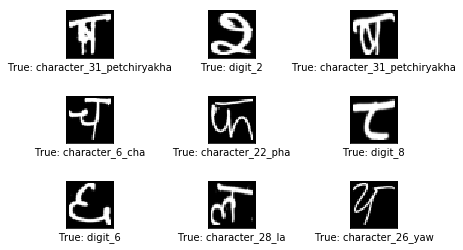

In [8]:
#Get some random images and their labels from the train set.
images, cls_true  = data.train.images, data.train.cls

%matplotlib inline
#Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [9]:
#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# 3. Tensorflow Functions for CNN

In [10]:
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

### Convolutional layer

In [12]:
def create_convolutional_layer(input,              # The previous layer.
                               num_input_channels, # Num. channels in prev. layer.
                               conv_filter_size,   # Width and height of each filter.
                               num_filters,        # Number of filters.
                               use_pooling=True):  # Use 2x2 max-pooling.
    
    ## Define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    
    ## Create biases using the create_biases function which are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')
    
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    # We return both the resulting layer and the filter-weights because we will plot the weights later.
    return layer, weights

### Flattened Layer

In [13]:
def create_flatten_layer(layer):
    
    #Getting the shape of the layer from the previous layer.
    layer_shape = layer.get_shape()

    #Number of features will be img_height * img_width* num_channels.
    num_features = layer_shape[1:4].num_elements()

    #Flatten the layer so we shall have to reshape to num_features
    flattened_layer = tf.reshape(layer, [-1, num_features])

    # Return both the flattened layer and the number of features.
    return flattened_layer, num_features

### Fully Connected Layer

In [14]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    #Calculate the layer as the matrix multiplication of the input and weights, 
    #and add the bias-values, using matmul function
    layer = tf.matmul(input, weights) + biases
    
    #Using RELU
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# 4. Training the model

In [15]:
#Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

#x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
#x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

#labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

#Conv layer 1
layer_conv1, weights_conv1 = create_convolutional_layer(input=x,
                                                        num_input_channels=num_channels,
                                                        conv_filter_size=filter_size_conv1,
                                                        num_filters=num_filters_conv1,
                                                        use_pooling=True)

#Conv layer 2
layer_conv2, weights_conv2 = create_convolutional_layer(input=layer_conv1,
                                                        num_input_channels=num_filters_conv1,
                                                        conv_filter_size=filter_size_conv2,
                                                        num_filters=num_filters_conv2,
                                                        use_pooling=True)

#Conv layer 3
layer_conv3, weights_conv3 = create_convolutional_layer(input=layer_conv2,
                                                        num_input_channels=num_filters_conv2,
                                                        conv_filter_size=filter_size_conv3,
                                                        num_filters=num_filters_conv3,
                                                        use_pooling=True)
          
#Flatten Layer
layer_flat, num_features = create_flatten_layer(layer_conv3)

#FC Layer 1
layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=num_features, #layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size,
                            use_relu=True)

#FC Layer 2
layer_fc2 = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size,
                            num_outputs=num_classes,
                            use_relu=False) 

#Predicted Class
y_pred = tf.nn.softmax(layer_fc2,name='y_pred')
y_pred_cls = tf.argmax(y_pred, dimension=1)


#Cost Function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

#Performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Tensorflow Run

### Create the TF session

In [50]:
session = tf.Session()

### Initialize the variables

In [17]:
session.run(tf.global_variables_initializer()) 

### Helper-function to perform iterations

In [18]:
def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --> Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [19]:
saver = tf.train.Saver()

#Counter for total number of iterations performed so far.
total_iterations = 0

def train(num_iterations):
    #Ensure we are updating the global variable rather than a local copy.
    global total_iterations
    
    #Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        
        
        #Get a batch of training examples - x_batch now holds a batch of images and y_true_batch are the 
        #true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)

        #Put the batch into a dict with the proper names for the placeholder variables in the TensorFlow graph.
        feed_dict_train =  {x:      x_batch,
                            y_true: y_true_batch}
        feed_dict_validatn = {x:      x_valid_batch,
                              y_true: y_valid_batch}

        #Run the optimizer using this training data batch
        session.run(optimizer, feed_dict=feed_dict_train)
        
        
        #Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0:
            val_loss = session.run(cost, feed_dict=feed_dict_validatn)
            epoch = int(i / int(data.train.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_train, feed_dict_validatn, val_loss)
            saver.save(session, './devanagari-model')
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    #Update the total number of iterations performed.
    total_iterations += num_iterations
    
    #Ending time.
    end_time = time.time()

    #Difference between start and end-times.
    time_dif = end_time - start_time

    #Print the time-taken.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))
    
#train(num_iterations=3000)

### Plot errors

In [20]:
def plot_example_errors(cls_pred, correct):
    #cls_pred is an array of the predicted class-number for all images in the test-set.
    #correct is a boolean array whether the predicted class is equal to the true class for each image in the test-set.

    #Negate the boolean array.
    incorrect = (correct == False)
    
    #Get the images from the test-set that have been incorrectly classified.
    images = data.valid.images[incorrect]
    
    #Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    #Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    #Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Plot confusion matrix

In [21]:
def plot_confusion_matrix(cls_pred):
    #Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    #Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    #Print the confusion matrix as text.
    print(cm)

    #Plot the confusion matrix as an image.
    plt.matshow(cm)

    #Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [22]:
def print_validation_accuracy(show_example_errors=False,
                              show_confusion_matrix=False):

    #Number of images in the test-set.
    num_test = len(data.valid.images)

    #Allocate an array for the predicted classes which will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    #Now calculate the predicted classes for the batches. We will just iterate through all the batches.
    i = 0

    while i < num_test:
        j = min(i + batch_size, num_test)

        images = data.valid.images[i:j, :] 
        labels = data.valid.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    #Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    #Calculate the number of correctly classified images. When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    #Classification accuracy is the number of correctly classified images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    #Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    #Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    #Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [23]:
train(num_iterations=1)

Training Epoch 1 --> Training Accuracy:   9.4%, Validation Accuracy:   0.0%,  Validation Loss: 3.817
Time elapsed: 0:00:02


In [24]:
print_validation_accuracy()

Accuracy on Test-Set: 2.9% (453 / 15640)


In [25]:
train(num_iterations=99)  # We already performed 1 iteration above.

Time elapsed: 0:00:05


Accuracy on Test-Set: 6.4% (1002 / 15640)
Example errors:


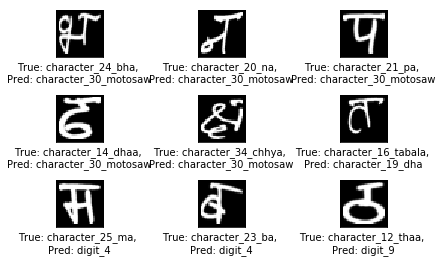

In [26]:
print_validation_accuracy(show_example_errors=True)

In [27]:
train(num_iterations=900)  # We performed 100 iterations above.

Time elapsed: 0:00:45


Accuracy on Test-Set: 69.8% (10919 / 15640)
Example errors:


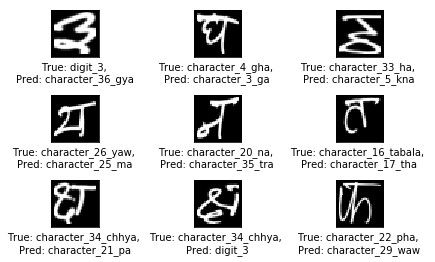

In [28]:
print_validation_accuracy(show_example_errors=True)

In [29]:
train(num_iterations=9000) # We performed 1000 iterations above.

Training Epoch 2 --> Training Accuracy:  68.8%, Validation Accuracy:  84.4%,  Validation Loss: 0.690
Training Epoch 3 --> Training Accuracy:  81.2%, Validation Accuracy:  87.5%,  Validation Loss: 0.635
Training Epoch 4 --> Training Accuracy:  87.5%, Validation Accuracy:  90.6%,  Validation Loss: 0.246
Training Epoch 5 --> Training Accuracy:  84.4%, Validation Accuracy:  87.5%,  Validation Loss: 0.203
Training Epoch 6 --> Training Accuracy:  90.6%, Validation Accuracy:  93.8%,  Validation Loss: 0.185
Time elapsed: 0:08:07


Accuracy on Test-Set: 92.7% (14497 / 15640)
Example errors:


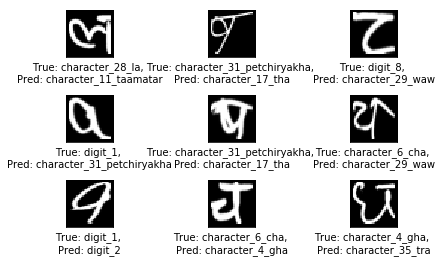

Confusion Matrix:
[[319   0   0 ...   0   0   0]
 [  0 359   0 ...   0   0   0]
 [  0  10 329 ...   1   0   0]
 ...
 [  0   0   2 ... 341   0   0]
 [  0  39   0 ...   0 299   0]
 [  0   0   1 ...   2   0 301]]


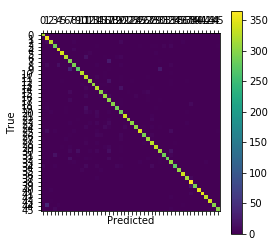

In [30]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

# 5. Prediction

In [31]:
def sample_prediction(test_file_name):
    for i in classes:
        test_imgfile = os.path.join(test_path, i, test_file_name)
        if os.path.isfile(test_imgfile):
            test_im = cv2.imread(test_imgfile)
    
            feed_dict_test = {
                x: test_im.reshape(1, img_size, img_size, num_channels),
                #y_true: np.array(data.valid.cls)
            }
        
            test_pred = session.run(y_pred, feed_dict_test)
            
    return classes[test_pred.argmax()]

In [32]:
test1 = '1416.png'
test2 = '1047.png'
print("Predicted class for test_ka: {}".format(sample_prediction(test1)))
print("Predicted class for test_tha: {}".format(sample_prediction(test2)))

Predicted class for test_ka: character_1_ka
Predicted class for test_tha: character_26_yaw


In [33]:
#Test on Sample Image
def preview_test_img(test_file_name):
    for i in classes:
        test_imgfile = os.path.join(test_path, i, test_file_name)
        if os.path.isfile(test_imgfile):
            print(test_imgfile)
            test_im = cv2.imread(test_imgfile)
            test_im = cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR) / 255
            preview_1 = plt.imshow(test_im.reshape(img_size, img_size, num_channels))

DevanagariHandwrittenCharacterDataset/DevanagariHandwrittenCharacterDataset/Test/character_1_ka/1416.png


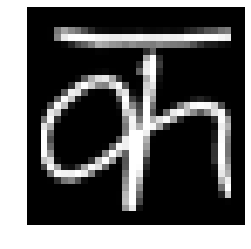

In [34]:
plt.axis('off')
preview_test_img(test1)

DevanagariHandwrittenCharacterDataset/DevanagariHandwrittenCharacterDataset/Test/character_17_tha/1047.png


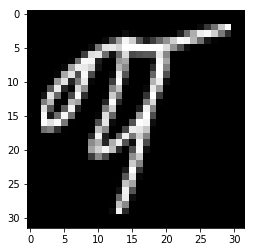

In [35]:
preview_test_img(test2)

### Visualization of Weights and Layers

In [36]:
#In trying to understand why the convolutional neural network can recognize images, we will now visualize the 
#weights of the convolutional filters and the resulting output images.

#Helper-function for plotting convolutional weights

def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [37]:
#Helper-function for plotting the output of a convolutional layer
def plot_conv_layer(layer, image):
    
    feed_dict = {x: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [38]:
#Helper-function for plotting an image.
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.show()

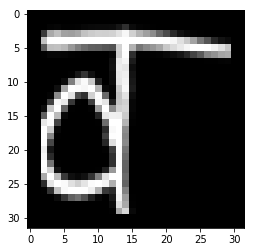

In [39]:
#Plot an image from the test-set which will be used as an example below.
image1 = test_images[0]
plot_image(image1)

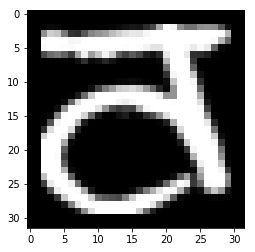

In [40]:
#Plot another example image from the test-set.
image2 = test_images[13]
plot_image(image2)

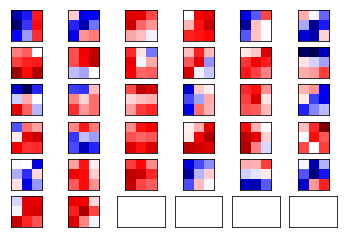

In [41]:
#Convolution Layer 1 Plot
plot_conv_weights(weights=weights_conv1)  #Note that positive weights are red and negative weights are blue.

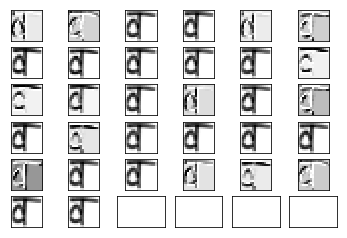

In [42]:
plot_conv_layer(layer=layer_conv1, image=image1)

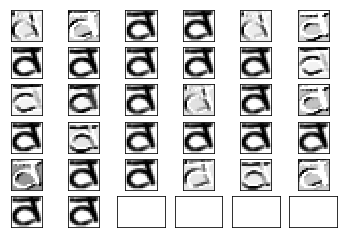

In [43]:
plot_conv_layer(layer=layer_conv1, image=image2)

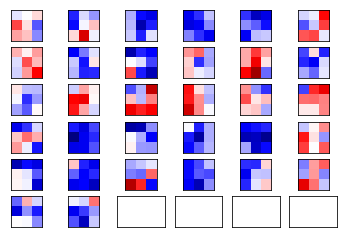

In [44]:
#Convolution Layer 2 Plot
plot_conv_weights(weights=weights_conv2, input_channel=0)

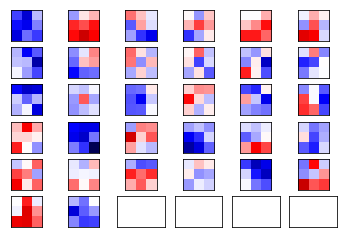

In [45]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

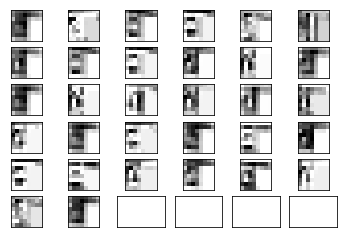

In [46]:
plot_conv_layer(layer=layer_conv2, image=image1)

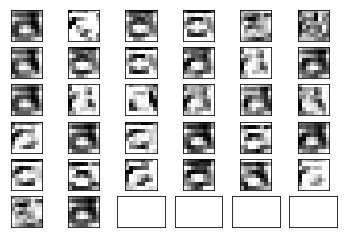

In [47]:
plot_conv_layer(layer=layer_conv2, image=image2)

## Write Test Predictions to CSV

In [48]:
def write_predictions(ims, ids):
     preds = session.run(y_pred, feed_dict={x: ims})
     result = pd.DataFrame(preds, columns=classes)
     result.loc[:, 'id'] = pd.Series(ids, index=result.index)
     pred_file = 'predictions.csv'
     result.to_csv(pred_file, index=False)

write_predictions(test_images, test_ids)

In [49]:
session.close() #Closing the session to release its resources.